## Effects of bandpass filtering
Neuropixels probes include a hardware bandpass filter from 0.5Hz-10kHz. The high pass removes voltage offset, and the low pass filter is necessary to remove signal that will not be adequately sampled at 30 kHz.
+ NP1.0 and NHP probes have an additional option to apply a 300 Hz high pass filter to the ap (action potential) band

Filtering is essential to remove noise (60 Hz, weird high frequency "stuff" in the lab). It also introduces artifacts:
+ Single pass filters in the time domain (most common) cause time lag. This is of particular importance when aligning spikes to LFP features.
+ At t=0, there can be hysteresis, especially if there is an offset in the signal.

Fixing those problems:
+ The lag problem is solved by filtering in the frequency domain (CatGT), or running the filter twice -- the second time with the time points reversed ('filtfilt' in both scipy and MATLAB).
+ Edge effects -- which occur throughout the data, because long recordings must be processed in batches -- can be avoided by processing batches with margin, which is then removed before assembling into the final filtered dataset. This can be tricky, but there are multiple, thoroughly debugged tools to use for your data processing pipeline.

In [ ]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path


In [82]:
# matplotlib configuration.
labelsize = 14
tick_labelsize = 12
 
matplotlib.rc('axes', linewidth=1),
matplotlib.rc('legend', fontsize=12, handlelength=2)

matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['figure.autolayout'] = True
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = tick_labelsize
matplotlib.rcParams['xtick.major.pad'] = 5
matplotlib.rcParams['xtick.major.size'] = 2
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.labelsize'] = tick_labelsize
matplotlib.rcParams['ytick.major.pad'] = 5
matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.right'] = True

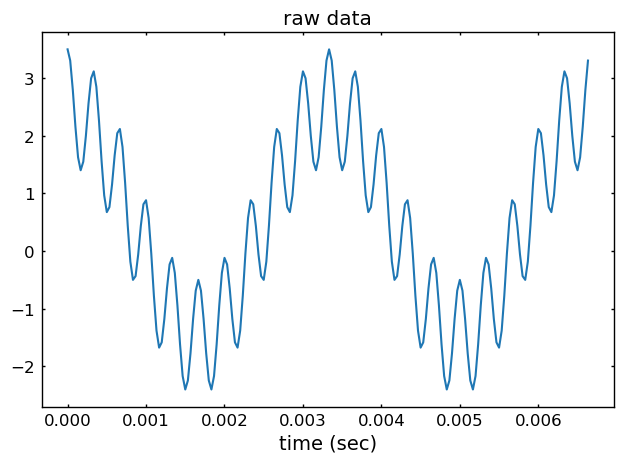

In [83]:
# Get parameters to generate a simple dataset
fs = 30000  # samples per second
# frequencies for the signals
f1 = 300 
f2 = 3000 

amp1 = 2 # arbitrary, pretend it's mV
amp2 = 1

offset = 0.5

time_span = 2 # in sec
npts = time_span*fs
tpts = np.arange(npts)/fs  # for plotting

raw_data = offset + amp1*(np.cos(2*np.pi*f1*tpts)) + amp2*(np.cos(2*np.pi*f2*tpts))

f1_per_samp = np.floor((1/f1)*fs).astype('int')
plt_pts = 2*f1_per_samp

plt.plot(tpts[:plt_pts],raw_data[:plt_pts])
plt.xlabel("time (sec)")
plt.title("raw data")
plt.show()

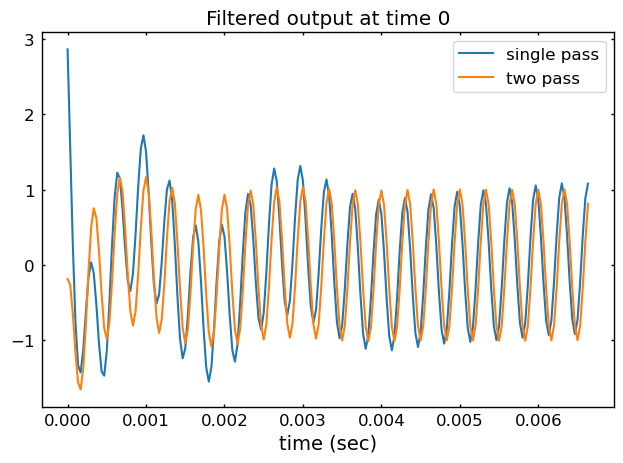

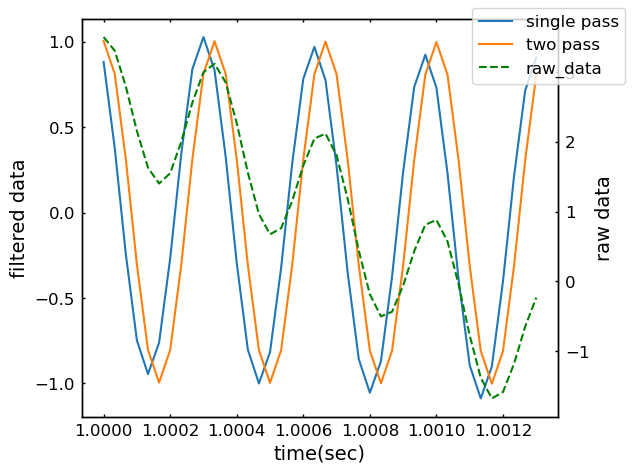

In [84]:
# set up butterworth filter
# Normalize the cutoff frequency to the Nyquist frequency
nyq = 0.5 * fs  # Nyquist frequency
cutoff_freq = 500
normal_cutoff = cutoff_freq / nyq
order = 6
b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)

single_pass = signal.lfilter(b, a, raw_data)
two_pass = signal.filtfilt(b,a,raw_data)

plt.plot(tpts[:plt_pts],single_pass[:plt_pts],tpts[:plt_pts],two_pass[:plt_pts])
plt.xlabel("time (sec)")
plt.legend(["single pass", "two pass"])
plt.title("Filtered output at time 0")
plt.show()


# plot a shorter range from the middle of the segment to show offset
# add raw data to see which filtered output is correct

# Create a figure and the first Axes object
fig, ax1 = plt.subplots()

# Create the second Axes object sharing the x-axis
ax2 = ax1.twinx()

start = np.floor(npts/2).astype('int')
stop = start + np.floor(0.2*plt_pts).astype('int')
ax1.plot(tpts[start:stop],single_pass[start:stop],tpts[start:stop],two_pass[start:stop] )
ax1.set_xlabel("time(sec)")
ax1.set_ylabel("filtered data")

ax2.plot(tpts[start:stop],raw_data[start:stop],"g--")
ax2.set_ylabel("raw data")

fig.legend(["single pass", "two pass", "raw_data"])
plt.show()


## Filtering real data
Here, we read in raw data hardcoding the number of channels and the voltage conversion factor. Those details vary with probe type and setttings, so in general code should read in the SGLX or OEP metadata. There's sample code for SGLX data [here](https://github.com/jenniferColonell/SpikeGLX_Datafile_Tools). 


In [94]:
fname = 'A531841_20231107_T112_g0_t0.exported.imec0.ap.bin'  # path to the binary file; the example is 1 sec export
dtype = np.dtype('int16')  # for spikeglx recordings 
nchannels = 385 # spikeglx recordings from 1.0 and 2.0

# calculate the sample size from the filesize
nsamples = os.path.getsize(fname)/(nchannels*dtype.itemsize)
dat = np.memmap(fname,
                mode='r', # open in read mode (safe)
                dtype=dtype,
                shape = (int(nsamples),int(nchannels)))

fs = 30000 # approximate - should read from metadata
real_tpts = np.arange(nsamples)/fs  
bit_to_uv = 1e6*(1.0/80)/(2*8192)   # for this generation of 2.0 probe -- different for the commercial version!



    

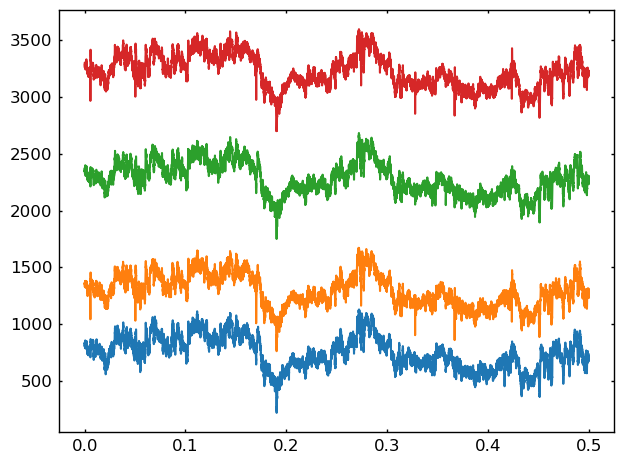

In [96]:
# plot a few channels -- in the example data, channels 73 to 75 have some nice spikes
ch_offset = 800 # in uV, to separate teh traces
chan_list = [73,74,75,76]
for i,ch in enumerate(chan_list):
    plt.plot(real_tpts[:15000], bit_to_uv*dat[:15000,ch] + i*ch_offset)
plt.set_xlabel("time_sec")
plt.show()

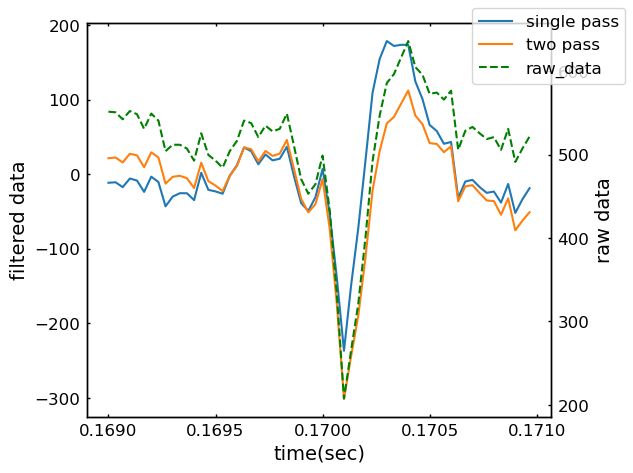

In [112]:
# Filter a channel, look at change in spike shape
ch = 74
real_raw_data = bit_to_uv*dat[:,ch].astype("float")

# set up butterworth filter
# Normalize the cutoff frequency to the Nyquist frequency
nyq = 0.5 * fs  # Nyquist frequency
cutoff_freq = 300
normal_cutoff = cutoff_freq / nyq
order = 3
b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)

single_pass = signal.lfilter(b, a, real_raw_data)
two_pass = signal.filtfilt(b,a,real_raw_data)

# plot a short range about a spike
t_center = 0.17 # in seconds
t_range = 0.002

# Create a figure and the first Axes object
fig, ax1 = plt.subplots()

# Create the second Axes object sharing the x-axis
ax2 = ax1.twinx()

start = np.floor((t_center-0.5*t_range)*fs).astype("int")
stop = start + np.floor(t_range*fs).astype("int")
ax1.plot(real_tpts[start:stop],single_pass[start:stop],real_tpts[start:stop],two_pass[start:stop] )
ax1.set_xlabel("time(sec)")
ax1.locator_params(axis='x', nbins=5)
ax1.set_ylabel("filtered data")

ax2.plot(real_tpts[start:stop],real_raw_data[start:stop],"g--")
ax2.set_ylabel("raw data")

fig.legend(["single pass", "two pass", "raw_data"])
plt.show()
